## Motor imagery decoding from EEG data using the Common Spatial Pattern (CSP)
https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html#ex-decoding-csp-eeg \
(modified according to dataset's original article)

In [1]:
import sys
sys.path.append('c:\\Users\\rokas\\Documents\\GitHub\\BCI\\mi-bci\\code')
from helper_functions import setup_logger, load_procesed_data
from helper_functions import process_mi_epochs
from datasets import Lee2019

log = setup_logger("Lee_preprocess")
dataset = Lee2019()

In [3]:
import os
os.getcwd()

'c:\\Users\\rokas\\Documents\\GitHub\\BCI\\mi-bci\\code\\notebooks\\Tutorials'

In [2]:
### loading 1 subject data ###

dataset_no = 20
paradigm = "MI"
subject = 44
run = 1
data = load_procesed_data(dataset_no, paradigm, subject, run, include=['epochs_raw', 'epochs_raw_autoreject'])


FileNotFoundError: File does not exist: "c:\Users\rokas\Documents\GitHub\BCI\mi-bci\code\notebooks\Tutorials\data\procesed\20\MI\44\1\s44.01_epochs_raw-epo.fif"

In [3]:
epochs = data["epochs_raw"]
epochs_autoreject = data["epochs_raw_autoreject"]

In [6]:
epochs_p = process_mi_epochs(epochs)
epochs_autoreject_p = process_mi_epochs(epochs_autoreject)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



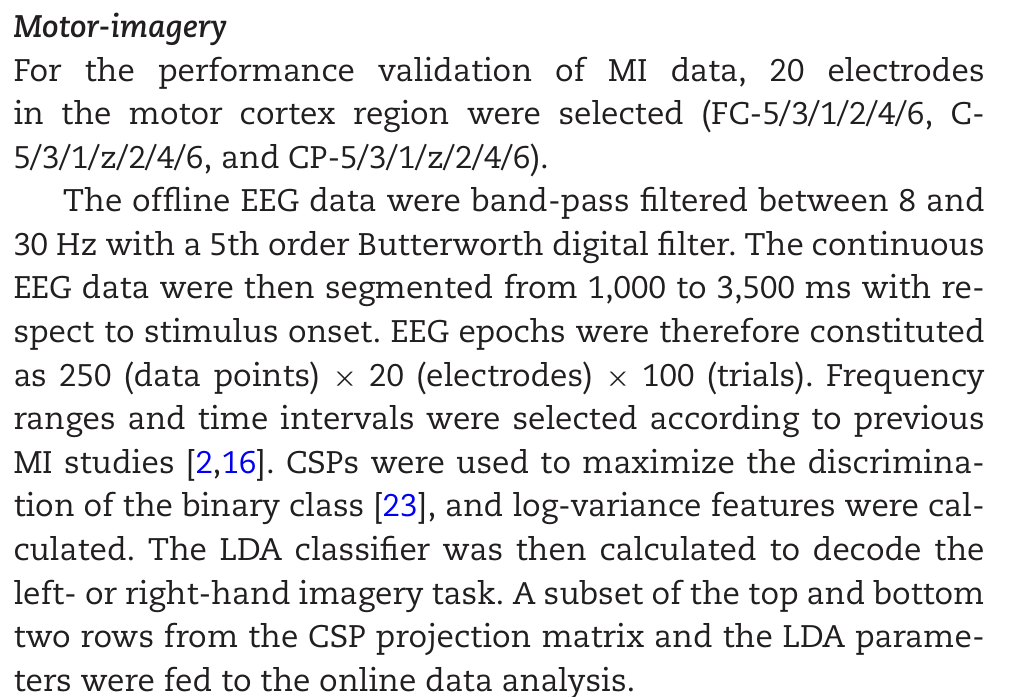

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from mne.decoding import CSP
from helper_functions import add_border_and_title
import os


def full_pipeline(epochs,subject=None,run=None,extra_mark= None, save=False):
    epochs_train = epochs.copy().crop(tmin=1.0, tmax=3.5) #as in original article
    labels = epochs.events[:, -1] - 1 #original labels are 1,2
    
    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    epochs_data = epochs.get_data(copy=False)
    epochs_data_train = epochs_train.get_data(copy=False)

    cv = ShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)

    # Assemble a classifier
    lda = LinearDiscriminantAnalysis()
    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([("CSP", csp), ("LDA", lda)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1.0 - class_balance)
    print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

    # plot CSP patterns estimated on full data for visualization
    csp.fit_transform(epochs_data, labels)

    csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)
    if save:
        if extra_mark == None:
            extra_mark = ''
        elif extra_mark != None:
            extra_mark = extra_mark + "_"
            
        path = os.path.join(os.getcwd(), 'data', 'plots', 'csp',f'dataset_no', f'{subject:02}')
        os.makedirs(path, exist_ok=True)
        save_path = os.path.join(path, f's{subject:02}.{run:02}_{extra_mark}CSP.png')
        plt.savefig(save_path)
        add_border_and_title(save_path, save_path,f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}",
                             border_size=0,title_color='black',title_bg_color='white')
        add_border_and_title(save_path, save_path, f's{subject:02}.{run:02}_{extra_mark}',
                             border_size=0,title_color='black',title_bg_color='white')
        

    sfreq = epochs.info["sfreq"]
    w_length = int(sfreq * 0.5)  # running classifier: window length
    w_step = int(sfreq * 0.1)  # running classifier: window step size
    w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

    scores_windows = []

    for train_idx, test_idx in cv_split:
        y_train, y_test = labels[train_idx], labels[test_idx]

        X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
        X_test = csp.transform(epochs_data_train[test_idx])

        # fit classifier
        lda.fit(X_train, y_train)
        # running classifier: test classifier on sliding window
        score_this_window = []
        for n in w_start:
            X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
            score_this_window.append(lda.score(X_test, y_test))
        scores_windows.append(score_this_window)

    # Plot scores over time
    w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

    plt.figure()
    plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
    plt.axvline(0, linestyle="--", color="k", label="Onset")
    plt.axhline(0.5, linestyle="-", color="k", label="Chance")
    plt.xlabel("time (s)")
    plt.ylabel("classification accuracy")
    plt.title("Classification score over time")
    plt.legend(loc="lower right")
    plt.show()
    
    if save:
        save_path = os.path.join(path, f's{subject:02}.{run:02}_{extra_mark}sliding_acc.png')
        plt.savefig(save_path)
        add_border_and_title(save_path, save_path, f's{subject:02}.{run:02}_{extra_mark}',
                             border_size=0,title_color='black',title_bg_color='white')
    
    return_string = f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}"
    return return_string


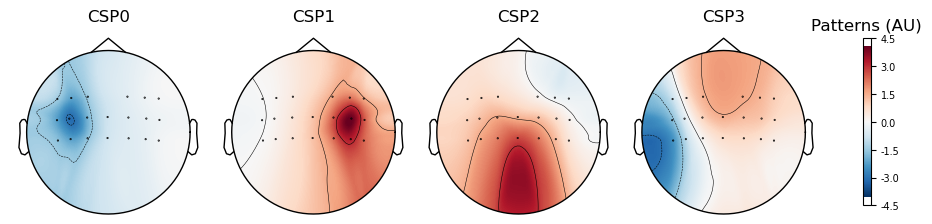

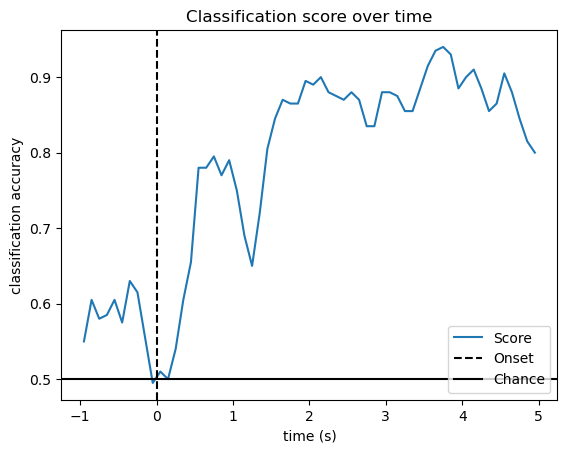

'Classification accuracy: 0.9049999999999999 / Chance level: 0.5'

In [8]:
sys.stdout = open(os.devnull, 'w')
full_pipeline(epochs_p)

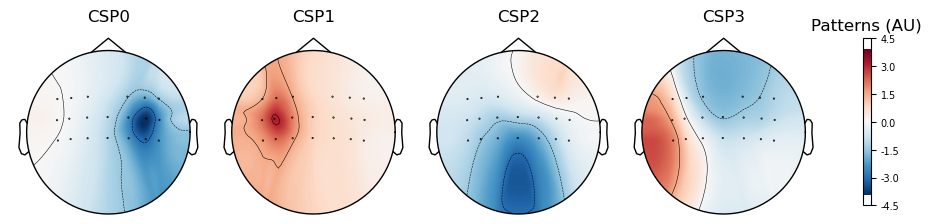

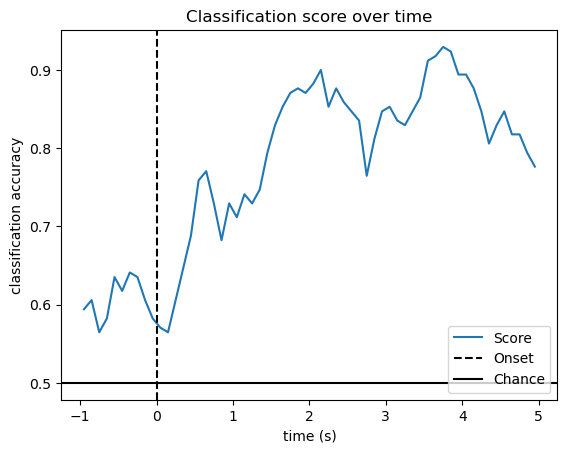

'Classification accuracy: 0.9294117647058824 / Chance level: 0.5176470588235293'

In [9]:
full_pipeline(epochs_autoreject_p)

In [26]:
import pandas as pd 
import os 
import glob
path_root = os.path.join(os.getcwd(), 'data', 'models','20','stats')
file_name_results = "*results.csv"
file_name_over_time ="*time.csv"
results = pd.read_csv(glob.glob(os.path.join(path_root,file_name_results))[0])
results_time = pd.read_csv(glob.glob(os.path.join(path_root, file_name_over_time))[0])

In [2]:
results.head()

,subject,run,extra_mark,mean_score,std_score,chance_level
0,1,1,epochs__,0.535000,0.095000,0.500000
1,1,1,autoreject__,0.807143,0.101267,0.537313
2,1,2,epochs__,0.665000,0.155000,0.500000
3,1,2,autoreject__,0.745000,0.093408,0.505155
4,2,1,epochs__,0.915000,0.050249,0.500000


In [14]:
# Calculate mean and std for individual runs
df = results
combined_data = df.groupby(['subject', 'extra_mark'], as_index=False)[['mean_score','std_score']].mean()
combined_data['run'] = 'Combined'

# Concatenating combined data with original
df = df.drop('chance_level', axis=1)
df_combined = pd.concat([df, combined_data])


# Correctly calculating std score for individual and combined runs
score_summary_corrected = df.groupby(['extra_mark', 'run']).agg(
    mean_score=('mean_score', 'mean'),
    std_score=('std_score', 'mean')
).reset_index()

# Adding combined runs mean and std score
combined_summary = df.groupby(['extra_mark'], as_index=False).agg(
    mean_score=('mean_score', 'mean'),
    std_score=('std_score', 'mean')
)
combined_summary['run'] = 'Combined'

# Concatenating the individual and combined run data
score_summary_corrected = pd.concat([score_summary_corrected, combined_summary])
score_summary_corrected

,extra_mark,run,mean_score,std_score
0,autoreject__,1,0.695957,0.093609
1,autoreject__,2,0.709328,0.089205
2,epochs__,1,0.708222,0.083666
3,epochs__,2,0.711818,0.082330
0,autoreject__,Combined,0.702567,0.091432
1,epochs__,Combined,0.710000,0.083006


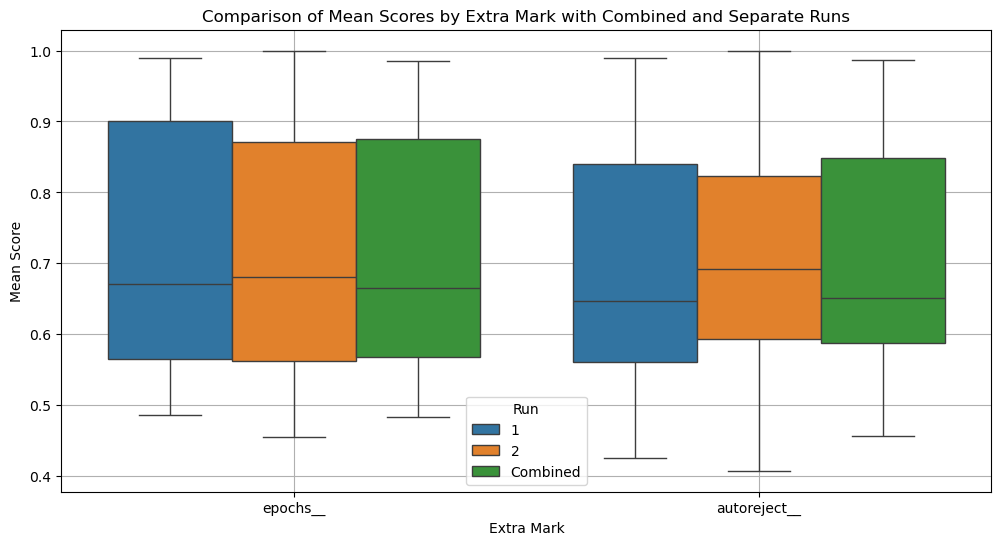

In [8]:
plt.figure(figsize=(12, 6))

sns.boxplot(x='extra_mark', y='mean_score', hue='run', data=df_combined)

plt.title('Comparison of Mean Scores by Extra Mark with Combined and Separate Runs')
plt.xlabel('Extra Mark')
plt.ylabel('Mean Score')
plt.grid(True)
plt.legend(title='Run')
plt.show()

C:\Users\rokas\AppData\Local\Temp\ipykernel_99032\2452827355.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['x_position'] = df_filtered.apply(


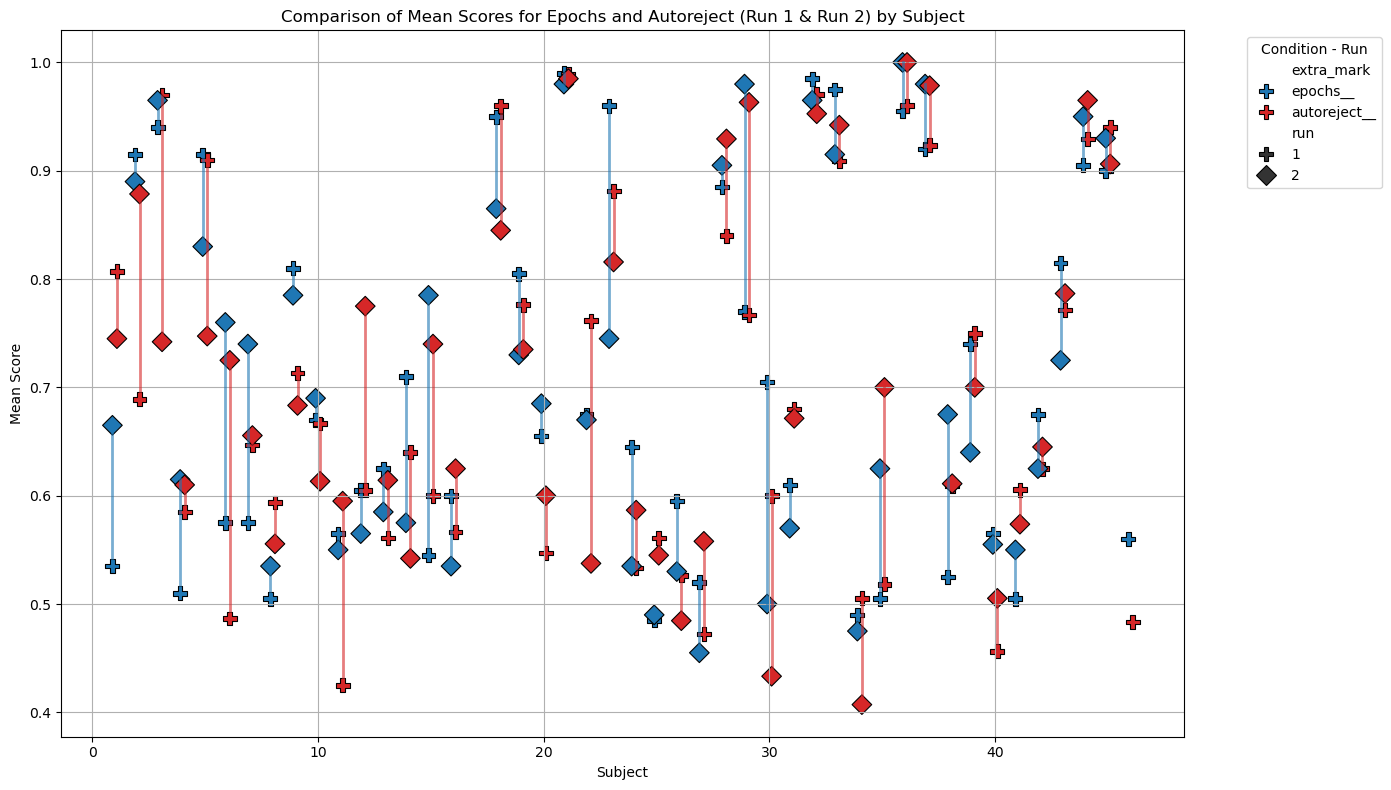

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define base colors for epochs and autoreject
base_palette = {
    'epochs__': '#1f77b4',      # Blue for epochs
    'autoreject__': '#d62728'   # Red for autoreject
}

# Filter out 'Combined' runs
df_filtered = df_combined[df_combined['run'] != 'Combined']

# Create an offset for epochs__ and autoreject__ to avoid overlap
# We'll shift epochs__ to the left and autoreject__ to the right slightly
offset = 0.1
df_filtered['x_position'] = df_filtered.apply(
    lambda row: row['subject'] - offset if row['extra_mark'] == 'epochs__' else row['subject'] + offset, axis=1
)

# Set figure size
plt.figure(figsize=(14, 8))

# Create lines connecting points for the same subject and condition
for subject in df_filtered['subject'].unique():
    for condition in ['epochs__', 'autoreject__']:
        subject_data = df_filtered[(df_filtered['subject'] == subject) & (df_filtered['extra_mark'] == condition)]
        if len(subject_data) > 1:
            plt.plot(subject_data['x_position'], subject_data['mean_score'], 
                     color=base_palette[condition], linewidth=2, alpha=0.6)

# Create a scatterplot for each subject with points colored by condition and style by run
sns.scatterplot(
    x='x_position', 
    y='mean_score', 
    hue='extra_mark',     # Color points by extra_mark (epochs or autoreject)
    style='run',          # Different marker style for run (run 1, run 2)
    markers=['P', 'D'],   # Use "P" (plus) for run 1, "D" (diamond) for run 2
    data=df_filtered,
    palette=base_palette,  # Use the base palette for clear color distinction
    s=100,                # Set size of the points
    edgecolor='black',    # Add edge color for better visibility
)

# Set plot title and labels
plt.title('Comparison of Mean Scores for Epochs and Autoreject (Run 1 & Run 2) by Subject')
plt.xlabel('Subject')
plt.ylabel('Mean Score')

# Improve legend to avoid overlap
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Condition - Run')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
df_time = results_time

C:\Users\rokas\AppData\Local\Temp\ipykernel_99032\3700408209.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


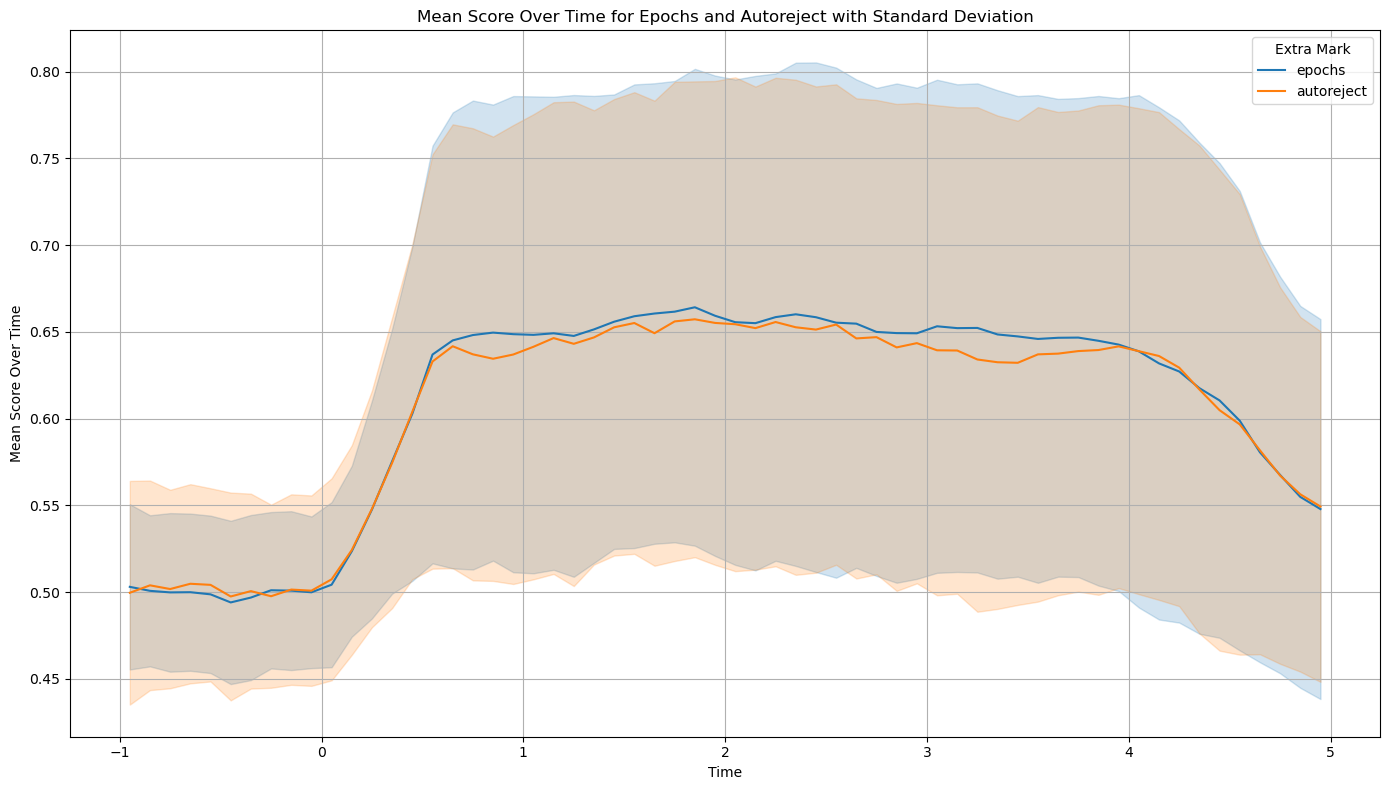

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(14, 8))

# Plotting with seaborn's lineplot including a shadow of variation (standard deviation)
sns.lineplot(
    x='time', 
    y='mean_score_over_time', 
    hue='extra_mark', 
    data=df_time, 
    ci='sd'  # Adding a shadow to represent the standard deviation
)

# Add titles and labels
plt.title('Mean Score Over Time for Epochs and Autoreject with Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Mean Score Over Time')

# Add grid and customize legend
plt.grid(True)
plt.legend(title='Extra Mark')

# Display the plot
plt.tight_layout()
plt.show()


,subject,run,extra_mark,mean_score,std_score
0,1,1,epochs__,0.535000,0.095000
1,1,1,autoreject__,0.807143,0.101267
2,1,2,epochs__,0.665000,0.155000
3,1,2,autoreject__,0.745000,0.093408
4,2,1,epochs__,0.915000,0.050249
...,...,...,...,...,...
173,45,1,autoreject__,0.940000,0.058310
174,45,2,epochs__,0.930000,0.040000
175,45,2,autoreject__,0.906250,0.093750
176,46,1,epochs__,0.560000,0.111355


In [184]:
results_autoreject[mean_score]

NameError: name 'mean_score' is not defined

In [189]:
results = pd.read_csv(glob.glob(os.path.join(path_root,file_name_results))[0])
results = results.drop('chance_level', axis=1)

results_epochs = results[results['extra_mark'] == 'epochs__'].reset_index(drop=True).drop(['extra_mark','std_score'], axis=1)
results_autoreject = results[results['extra_mark'] == 'autoreject__'].reset_index(drop=True).drop(['extra_mark','std_score'], axis=1)

def epo(epoch):
    epoch['mean_score'] *= 100
    results_pivot = epoch.pivot(index='subject', columns='run', values='mean_score').reset_index()
    results_pivot['subject'] = 's' + results_pivot['subject'].astype(str)
    pivoted_df = results_pivot.drop(columns='run', errors='ignore')
    pivoted_df = results_pivot.rename(columns={1: 'Se1', 2: 'Se2'})
    pivoted_df = pivoted_df.rename_axis(None, axis=1).reset_index(drop=True)
    return pivoted_df

df_epochs = epo(results_epochs)
df_auto = epo(results_autoreject)

In [190]:
data = """
Se1,Se2
61.0,83.0
96.0,86.0
95.0,94.0
53.0,57.0
94.0,81.0
77.0,88.0
49.0,71.0
57.0,66.0
86.0,71.0
65.0,61.0
47.0,50.0
46.0,58.0
56.0,54.0
58.0,48.0
55.0,57.0
53.0,69.0
83.0,42.0
92.0,82.0
82.0,89.0
59.0,73.0
98.0,100.0
77.0,85.0
54.0,68.0
49.0,54.0
54.0,57.0
49.0,44.0
56.0,70.0
94.0,97.0
99.0,98.0
76.0,66.0
58.0,57.0
56.0,97.0
99.0,89.0
48.0,47.0
52.0,52.0
97.0,94.0
93.0,81.0
56.0,52.0
64.0,52.0
46.0,58.0
62.0,48.0
47.0,63.0
77.0,86.0
99.0,100.0
93.0,99.0
53.0,58.0
44.0,59.0
50.0,49.0
63.0,62.0
59.0,58.0
71.0,52.0
72.0,72.0
50.0,54.0
53.0,45.0
67.3,68.6
18.3,17.6
"""

# Converting this into a pandas DataFrame
import pandas as pd
from io import StringIO

df_article = pd.read_csv(StringIO(data))

In [196]:
# Assuming `existing_df` is your current DataFrame
# `new_df` is the DataFrame containing the Se1 and Se2 columns

df_epochs['Se1(article)'] = df_article['Se1']
df_epochs['Se2(article)'] = df_article['Se2']
df_epochs['Se1(article)_diff'] = df_epochs['Se1'] - df_epochs['Se1(article)']
df_epochs['Se2(article)_diff'] = df_epochs['Se2'] - df_epochs['Se2(article)']

df_auto['Se1(article)'] = df_article['Se1']
df_auto['Se2(article)'] = df_article['Se2']
df_auto['Se1(article)_diff'] = df_auto['Se1'] - df_auto['Se1(article)']
df_auto['Se2(article)_diff'] = df_auto['Se2'] - df_auto['Se2(article)']

In [207]:
df_epochs.dropna()

,subject,Se1,Se2,Se1(article),Se2(article),Se1(article)_diff,Se2(article)_diff
0,s1,53.5,66.5,61.0,83.0,-7.5,-16.5
1,s2,91.5,89.0,96.0,86.0,-4.5,3.0
2,s3,94.0,96.5,95.0,94.0,-1.0,2.5
3,s4,51.0,61.5,53.0,57.0,-2.0,4.5
4,s5,91.5,83.0,94.0,81.0,-2.5,2.0
5,s6,57.5,76.0,77.0,88.0,-19.5,-12.0
6,s7,57.5,74.0,49.0,71.0,8.5,3.0
7,s8,50.5,53.5,57.0,66.0,-6.5,-12.5
8,s9,81.0,78.5,86.0,71.0,-5.0,7.5
9,s10,67.0,69.0,65.0,61.0,2.0,8.0


In [208]:
df_epochs.describe()

,Se1,Se2,Se1(article),Se2(article),Se1(article)_diff,Se2(article)_diff
count,45.000000,44.000000,45.000000,45.000000,45.000000,44.000000
mean,70.822222,71.181818,69.266667,70.977778,1.555556,0.840909
std,17.081075,16.892647,19.058999,18.035935,21.167681,19.026839
min,48.500000,45.500000,46.000000,42.000000,-50.000000,-48.000000
25%,56.500000,56.250000,54.000000,57.000000,-7.500000,-9.375000
50%,67.000000,68.000000,61.000000,69.000000,2.000000,2.250000
75%,90.000000,87.125000,92.000000,86.000000,12.000000,9.125000
max,99.000000,100.000000,99.000000,100.000000,43.500000,48.000000


In [205]:
df_auto.dropna().describe()

,Se1,Se2,Se1(article),Se2(article),Se1(article)_diff,Se2(article)_diff
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,70.078918,70.932814,68.727273,70.340909,1.351645,0.591904
std,16.874526,16.289838,18.928708,17.725219,20.965042,21.138712
min,42.500000,40.714286,46.000000,42.000000,-48.473684,-54.666667
25%,56.527778,59.291667,53.750000,56.250000,-9.588235,-8.509615
50%,65.666667,69.166667,60.000000,68.500000,1.833333,-0.149123
75%,85.031250,82.309211,87.500000,86.000000,14.513889,12.758772
max,98.947368,100.000000,99.000000,100.000000,44.000000,48.000000
